# Scaling up hyperparameter optimization with Kubernetes and XGBoost GPU algorithm

Choosing an optimal set of hyperparameters is a daunting task, especially for algorithms like XGBoost that have many hyperparameters to tune. In this notebook, we will show how to speed up hyperparameter optimization by running multiple training jobs in parallel on a Kubernetes cluster.

# Prerequisites
Please follow instructions in [Accelerating ETL on KubeFlow with RAPIDS](https://developer.nvidia.com/blog/accelerating-etl-on-kubeflow-with-rapids/) to set up a GPU-enabled Kubernetes cluster and Kubeflow.

# Install system packages

We'll need a MySQL client to store the result of hyperparameter optimization.

In [1]:
!apt-get update && apt-get install -y default-libmysqlclient-dev build-essential

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:3 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]                
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [705 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1593 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2

In [2]:
!pip install mysqlclient

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysqlclient: filename=mysqlclient-2.1.1-cp39-cp39-linux_x86_64.whl size=60515 sha256=df065fbed2096127bd77b6d1f191c70cab81eefceadfb96cfca93dd04676505a
  Stored in directory: /root/.cache/pip/wheels/f3/a5/27/c6312d8008951cfd5511684378a9e057b82006c70e1fea6107
Successfully built mysqlclient


We'll also need extra Python packages:

In [3]:
!pip install dask_kubernetes optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.5/205.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.6/906.6 kB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 26.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

# Set up Dask cluster

Let us set up a Dask cluster using the `KubeCluster` class. Fill in the following variables, depending on the configuration of your Kubernetes cluster.

In [4]:
# Choose the same RAPIDS image you used for launching the notebook session
rapids_image = "rapidsai/rapidsai-core:22.08-cuda11.5-runtime-ubuntu20.04-py3.9"
# Use the number of worker nodes in your Kubernetes cluster.
n_workers = 5

In [5]:
from dask_kubernetes.experimental import KubeCluster

cluster = KubeCluster(name="rapids-dask",
                      image=rapids_image,
                      worker_command="dask-cuda-worker",
                      n_workers=n_workers,
                      resources={"limits": {"nvidia.com/gpu": "1"}},
                      env={"DISABLE_JUPYTER": "true"})

/tmp/ipykernel_81/3253668050.py:1: DeprecationWarning: Yay KubeCluster is no longer experimental 🎉. You can import it directly from dask_kubernetes or explicitly from dask_kubernetes.operator
  from dask_kubernetes.experimental import KubeCluster
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f65e125be80>


In [6]:
cluster

Dashboard: /notebook/kubeflow-user-example-com/rapids/proxy/rapids-dask-scheduler.kubeflow-user-example-com:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.36.4.14:8786,Workers: 0
Dashboard: /notebook/kubeflow-user-example-com/rapids/proxy/10.36.4.14:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Perform hyperparameter optimization with a toy example

To store the result of hyperparameter optimization, we use the MySQL database that comes with the Kubeflow installation.

First, obtain the IP address of the MySQL service by running:
```
kubectl get pods -n  kubeflow
kubectl describe pods/mysql-[unique id] -n  kubeflow
```
Then save the IP address to the following variable.

In [7]:
ip_address = "10.36.5.13"

Now we can run hyperparameter optimization. The workers will run multiple training jobs in parallel.

In [8]:
def objective(trial):
    x = trial.suggest_uniform("x", -10, 10)
    return (x - 2) ** 2

In [9]:
import optuna
import joblib
import dask.distributed

with dask.distributed.Client(cluster) as client:
    study = optuna.create_study(storage=f"mysql://root@{ip_address}:3306/metadb")
    # Optimize in parallel on your Dask cluster
    with joblib.parallel_backend("dask", client=client):
        study.optimize(objective, n_trials=100, n_jobs=-1)
    print(f"best_params = {study.best_params}")

/opt/conda/envs/rapids/lib/python3.9/site-packages/distributed/client.py:1309: VersionMismatchWarning: Mismatched versions found

+-------------+----------+------------------------+------------------------+
| Package     | client   | scheduler              | workers                |
+-------------+----------+------------------------+------------------------+
| dask        | 2022.9.2 | 2022.7.1+28.g386b4753f | 2022.7.1+28.g386b4753f |
| distributed | 2022.9.2 | 2022.7.1               | 2022.7.1               |
+-------------+----------+------------------------+------------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
[I 2022-10-13 11:51:14,073] A new study created in RDB with name: no-name-5c16ffe6-4797-4297-a054-7e8e9df9cef6
/tmp/ipykernel_81/638899847.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

best_params = {'x': 1.9886776484144286}


In [10]:
study.best_params

{'x': 1.9886776484144286}

In [11]:
study.best_value

0.0001281956454272907

# Perform hyperparameter optimization with XGBoost GPU algorithm

Now let's try optimizing hyperparameters for an XGBoost model.

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from optuna.samplers import RandomSampler

def objective(trial):
    X, y = load_breast_cancer(return_X_y=True)
    params = {
        "n_estimators": 10,
        "verbosity": 0,
        "tree_method": "gpu_hist",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "logloss"
    }
    clf = xgb.XGBClassifier(**params)
    fold = KFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(clf, X, y, cv=fold, scoring='neg_log_loss')
    return score.mean()

In [13]:
with dask.distributed.Client(cluster) as client:
    study = optuna.create_study(storage=f"mysql://root@{ip_address}:3306/metadb",
                                sampler=RandomSampler(seed=0),
                                direction="maximize")
    # Optimize in parallel on your Dask cluster
    with joblib.parallel_backend("dask", client=client):
        study.optimize(objective, n_trials=250, n_jobs=-1)
    print(f"best_params = {study.best_params}")

/opt/conda/envs/rapids/lib/python3.9/site-packages/distributed/client.py:1309: VersionMismatchWarning: Mismatched versions found

+-------------+----------+------------------------+------------------------+
| Package     | client   | scheduler              | workers                |
+-------------+----------+------------------------+------------------------+
| dask        | 2022.9.2 | 2022.7.1+28.g386b4753f | 2022.7.1+28.g386b4753f |
| distributed | 2022.9.2 | 2022.7.1               | 2022.7.1               |
+-------------+----------+------------------------+------------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
[I 2022-10-13 11:51:34,036] A new study created in RDB with name: no-name-7ef89192-25cd-49ae-8092-b2c2d72057c9
[I 2022-10-13 11:51:38,784] Trial 2 finished with value: -0.6669448063205514 and parameters: {'lambda': 5.707900857368992e-07, 'alpha': 0.1838497048003726, 'colsample_bytree': 0.6680669310056874, 'max_depth': 2, 'min_child_

best_params = {'alpha': 3.8504767388019487e-07, 'colsample_bytree': 0.6373446117668213, 'gamma': 1.7336801557775474e-07, 'lambda': 5.877826827646607, 'learning_rate': 0.7388204192001481, 'max_depth': 6, 'min_child_weight': 4.715241583502237e-05}


In [14]:
study.best_params

{'alpha': 3.8504767388019487e-07,
 'colsample_bytree': 0.6373446117668213,
 'gamma': 1.7336801557775474e-07,
 'lambda': 5.877826827646607,
 'learning_rate': 0.7388204192001481,
 'max_depth': 6,
 'min_child_weight': 4.715241583502237e-05}

In [15]:
study.best_value

-0.0962276021647531

Let's visualize the progress made by hyperparameter optimization.

In [16]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

/tmp/ipykernel_81/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

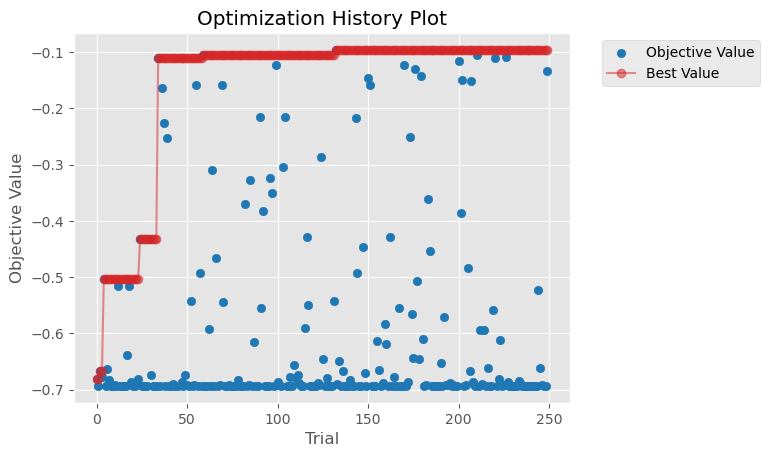

In [17]:
plot_optimization_history(study)

/tmp/ipykernel_81/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

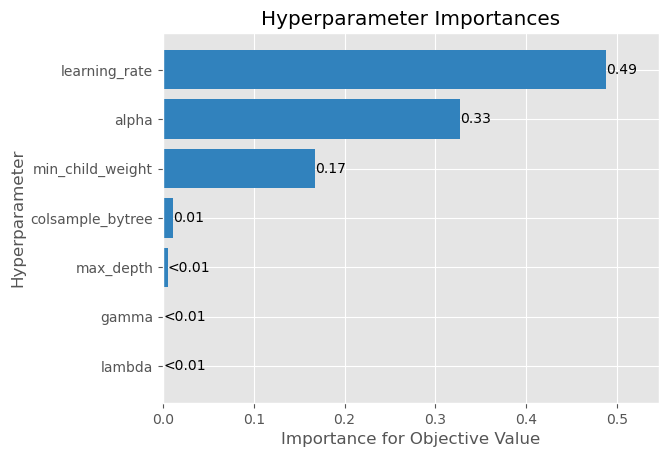

In [18]:
plot_param_importances(study)